In [1]:
import warnings
warnings.simplefilter("ignore")

# Práctica 4: Tarea de clasificación
### Base de Datos: Riesgo para la Salud Materna

##### Realizado por: Ixchel Dafne Avendaño Pacheco 

##### Matricula: 23265456


<img src=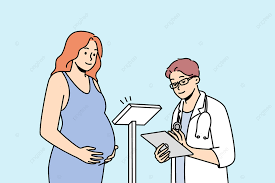 >

Importamos librerías 

In [2]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

Iniciamos cargando la base de datos.

In [3]:
df = pd.read_csv(r'Maternal.csv')

Mostramos el tipo de dato que tiene los atributos. También observamos que no hay datos faltantes, por lo que todos los atributos poseen su información completa.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 55.6 KB


#### Limpieza de datos

Desplegamos una gráfica de violín para visualizar las edades de las mujeres embarazadas.

Notamos que existe una cola que va de los 50 años hasta los 70. Sabemos además que es poco probable que una mujer en ese rando de edad se capaz de concebir un producto sano y funcional, por lo que modificamos esos valores para ahora cargar los datos en el rango de 22 a 35 que es la edad óptima para que una mujer se pueda embarazar de manera segura. 

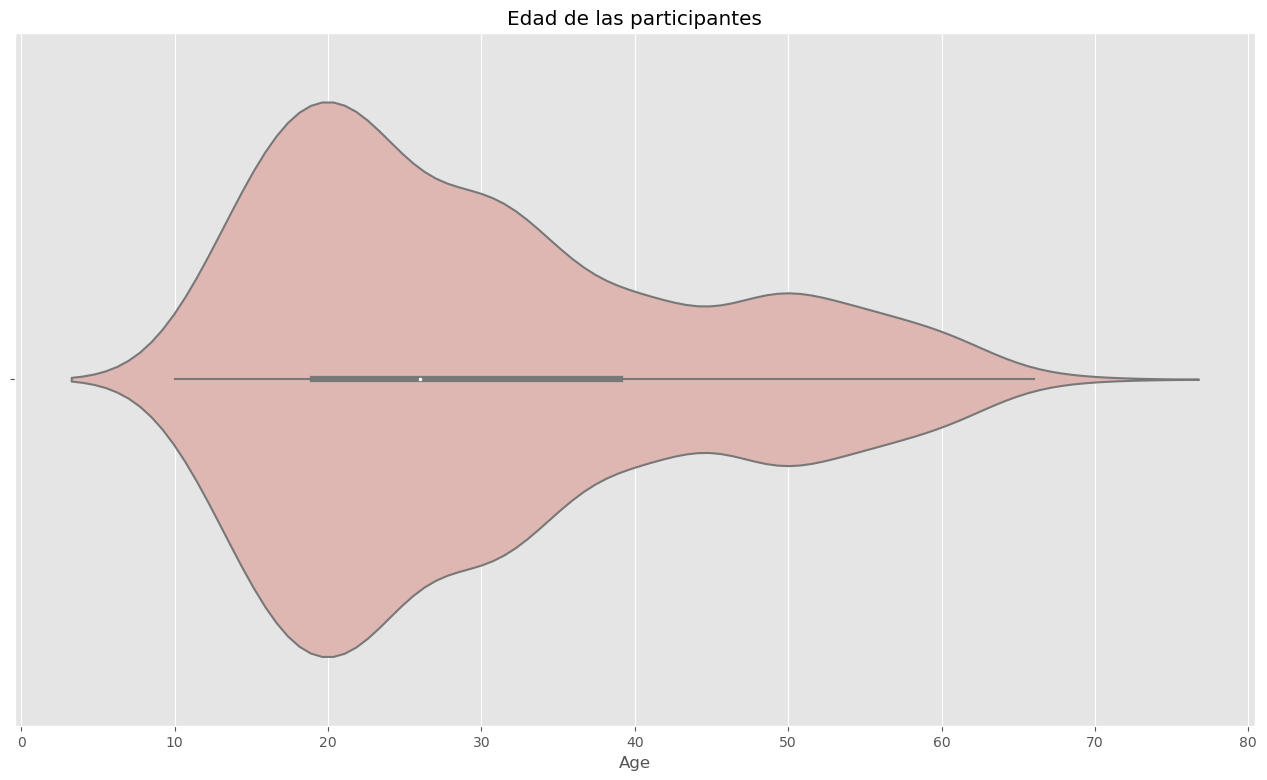

In [5]:
x=np.arange(len(df['Age']))
sns.violinplot(x=df["Age"], color='#E6B0AA');
plt.title("Edad de las participantes");

En la gráfica se puede observar que se han eliminado los vales de 50 a 70 y se han sustituido por valores entre 22 y 35. Esto se debe a que la edad de 22 a 35 años es más probable para que una mujer se embarace. Por otro lado, el embarazo después de los 50 años es poco probable y peligroso. A medida que las mujeres envejecen, su fertilidad disminuye y aumenta el riesgo de complicaciones durante el embarazo, como la diabetes gestacional, la hipertensión arterial y la preeclampsia.

In [6]:
df['Age'] = df['Age'].replace({70 : 29})
df['Age'] = df['Age'].replace({66 : 29})
df['Age'] = df['Age'].replace({65 : 22})
df['Age'] = df['Age'].replace({63 : 22})
df['Age'] = df['Age'].replace({62 : 32})
df['Age'] = df['Age'].replace({60 : 32})
df['Age'] = df['Age'].replace({59 : 28})
df['Age'] = df['Age'].replace({56 : 28})
df['Age'] = df['Age'].replace({55 : 35})
df['Age'] = df['Age'].replace({54 : 35})
df['Age'] = df['Age'].replace({51 : 34})
df['Age'] = df['Age'].replace({50 : 34})

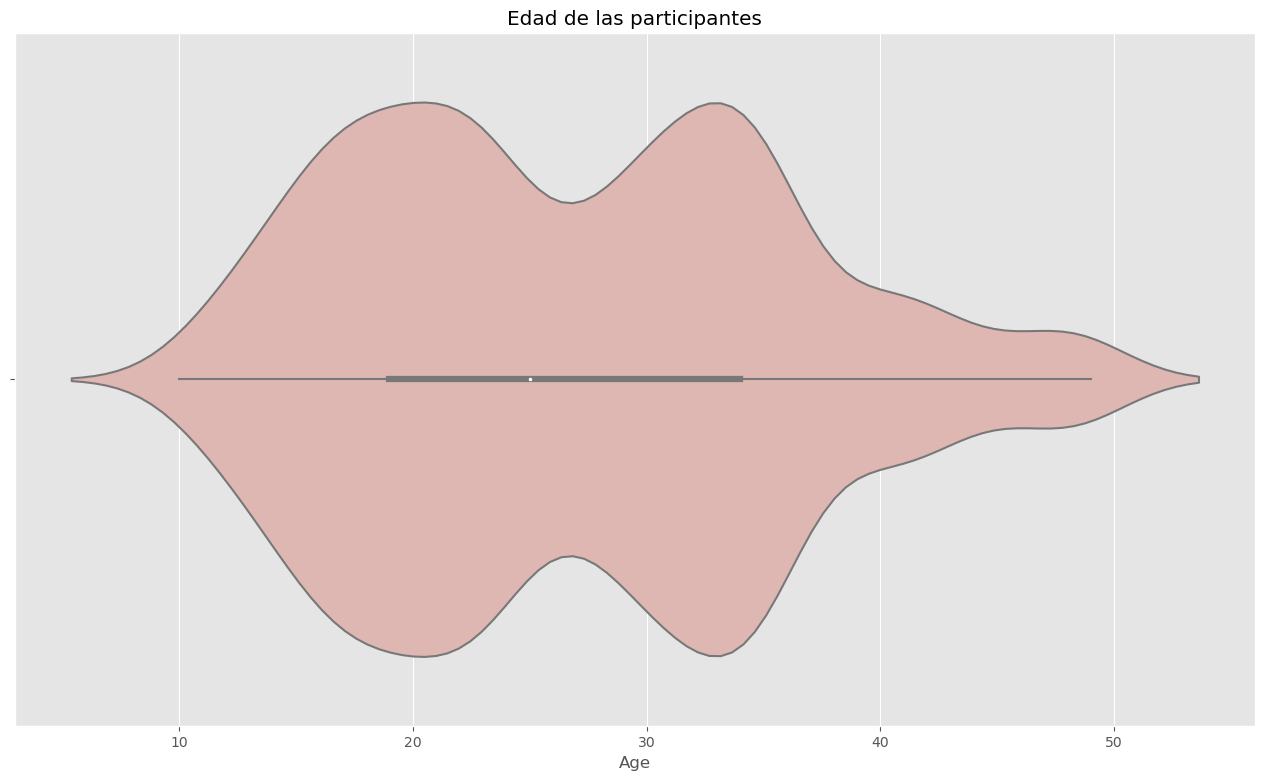

In [7]:
x=np.arange(len(df['Age']))
sns.violinplot(x=df["Age"], color='#E6B0AA');
plt.title("Edad de las participantes");

##  1er Objetivo 

Definimos las variables dependientes e independientes

In [8]:
X = df[['Age', 'SystolicBP', 'DiastolicBP','BS', 'BodyTemp', 'HeartRate']]
y = df[['RiskLevel']]

La función perf_measure esta diseñada para obtener TP, FP, TN, FN de una matriz de confusión MULTICLASE, por lo que esta función solamente será mandada a llamar.

In [9]:
#Función para obtener TP, FP, TN, FN de una matriz de confusión MULTICLASE
def perf_measure(y_actual, y_pred):
    class_id = set(y_actual).union(set(y_pred))
    TP = []
    FP = []
    TN = []
    FN = []

    for index ,_id in enumerate(class_id):
        TP.append(0)
        FP.append(0)
        TN.append(0)
        FN.append(0)
        for i in range(len(y_pred)):
            if y_actual[i] == y_pred[i] == _id:
                TP[index] += 1
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1
            if y_pred[i] != _id and y_actual[i] != y_pred[i]:
                FN[index] += 1


    return class_id,TP, FP, TN, FN

In [10]:
#Reshape para tener la y de manera adimensional  
y = np.array(y).reshape(1014)

### 1 <font color='green'>Árboles de Decisión</font>  


Los árboles de decisión son un tipo de algoritmo de aprendizaje automático supervisado que se utiliza para la clasificación y la regresión. Los árboles de decisión construyen un modelo de predicción a partir de un conjunto de datos de entrenamiento. El modelo se compone de un conjunto de reglas que se pueden utilizar para predecir el valor de una variable objetivo para una nueva observación.

In [11]:
Clasificador1 = DecisionTreeClassifier(max_depth=5, random_state=80)
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador1, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [12]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[365  37   4]
 [205  93  38]
 [ 24  41 207]]
Test accuracy =  0.6558185404339251


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [13]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[365, 93, 207] [229, 78, 42] [300, 572, 458] [120, 271, 307]


Se obtiene la sensibilidad y la especificidad. 

In [14]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [15]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.48789435069699194 
Specificity:  0.7921381774865992


### 2 <font color='#EE8983 '>Aprendizaje Bayesiano</font>

El aprendizaje bayesiano es un enfoque de aprendizaje automático que utiliza la teoría de la probabilidad bayesiana para hacer inferencias sobre los datos. La teoría de la probabilidad bayesiana se basa en la idea de que la probabilidad de un evento depende de la información previa que se tiene sobre ese evento.

In [16]:
Clasificador2 = GaussianNB()
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador2, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [17]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[346  36  24]
 [256  44  36]
 [ 43  54 175]]
Test accuracy =  0.5571992110453649


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [18]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[346, 44, 175] [299, 90, 60] [219, 521, 390] [150, 359, 389]


Se obtiene la sensibilidad y la especificidad. 

In [19]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [20]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.38619275461380725 
Specificity:  0.7156428119062698


### 3 <font color='#8B68D6 '>Aprendizaje basado en instancias </font>

El aprendizaje basado en instancias es un enfoque de aprendizaje automático en el que el modelo se construye a partir de un conjunto de datos de entrenamiento que contiene ejemplos de datos etiquetados. El modelo aprende a clasificar nuevas observaciones comparando las características de la observación con las características de las observaciones de entrenamiento.

In [21]:
Clasificador3 = KNeighborsClassifier(40)#Da valores similares para 2 y 40
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador3, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [22]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[249 145  12]
 [186 127  23]
 [ 98  38 136]]
Test accuracy =  0.504930966469428


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [23]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[249, 127, 136] [284, 183, 35] [263, 385, 376] [218, 319, 467]


Se obtiene la sensibilidad y la especificidad. 

In [24]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [25]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.33773087071240104 
Specificity:  0.6710353866317169


### 4 <font color='#B04ECB'>Máquinas de soporte vectorial (SVM)</font> 

In [26]:
Clasificador4 = SVC(kernel="linear", C=0.025, random_state=12)
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador4, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [27]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[333  63  10]
 [178 114  44]
 [ 44  58 170]]
Test accuracy =  0.6084812623274162


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [28]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[333, 114, 170] [222, 121, 54] [284, 503, 447] [175, 276, 343]


Se obtiene la sensibilidad y la especificidad. 

In [29]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [30]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.4372785258681786 
Specificity:  0.756591048436542


### 5 <font color='#4E7FCB '>Redes neuronales</font>

El proceso de aprendizaje de las redes neuronales se llama entrenamiento. El entrenamiento se lleva a cabo utilizando un algoritmo de aprendizaje automático. Los algoritmos de aprendizaje automático se utilizan para ajustar los pesos y los sesgos de los nodos de la red neuronal. Los pesos y los sesgos controlan cómo se procesan las entradas en la red neuronal.

In [31]:
Clasificador5 = MLPClassifier(alpha=1, max_iter=1000, random_state=80)
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador5, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [32]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[331  66   9]
 [210  81  45]
 [ 75  35 162]]
Test accuracy =  0.5660749506903353


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [33]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[331, 81, 162] [285, 101, 54] [243, 493, 412] [155, 339, 386]


Se obtiene la sensibilidad y la especificidad. 

In [34]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [35]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.3947730398899587 
Specificity:  0.7229219143576826


### 6 <font color='#DF5B91 '>AdaBoost</font>
AdaBoost funciona entrenando un conjunto de clasificadores débiles, cada uno de los cuales se enfoca en las observaciones que fueron mal clasificadas por los clasificadores anteriores. Los pesos de las observaciones se actualizan después de cada iteración para que los clasificadores futuros se centren en las observaciones que son más difíciles de clasificar.

In [36]:
Clasificador6 = AdaBoostClassifier(random_state=42)
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador6, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [37]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[284  93  29]
 [168 114  54]
 [ 27 139 106]]
Test accuracy =  0.4970414201183432


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [38]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[284, 114, 106] [195, 232, 83] [220, 390, 398] [315, 278, 427]


Se obtiene la sensibilidad y la especificidad. 

In [39]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [40]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.33070866141732286 
Specificity:  0.6640316205533597


### 7 <font color='#5B6FDF '>Random Forest</font>


Random Forest es un algoritmo de aprendizaje automático supervisado que se utiliza para la clasificación y la regresión. Random Forest es un conjunto de árboles de decisión aleatorios.
Random Forest funciona construyendo un conjunto de árboles de decisión aleatorios. Cada árbol de decisión se construye sobre un subconjunto aleatorio de los datos de entrenamiento. Las observaciones que se utilizan para construir un árbol de decisión son seleccionadas al azar sin reemplazo.

In [41]:
Clasificador7 = RandomForestClassifier(max_depth=6, n_estimators=15, max_features=3, random_state=42)
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador7, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [42]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[318  82   6]
 [191  96  49]
 [ 25  44 203]]
Test accuracy =  0.6084812623274162


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [43]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[318, 96, 203] [216, 126, 55] [299, 521, 414] [181, 271, 342]


Se obtiene la sensibilidad y la especificidad. 

In [44]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [45]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.4372785258681786 
Specificity:  0.756591048436542


### 8 <font color='#5B6FDF '>QDA</font>

QDA, o Quadratic Discriminant Analysis, es un algoritmo de clasificación supervisado que se utiliza para clasificar las observaciones en diferentes categorías. QDA es un modelo probabilístico que se basa en la teoría de la probabilidad bayesiana.
QDA es un algoritmo robusto que es menos propenso al sobreajuste que otros algoritmos de clasificación. QDA también puede manejar datos complejos o no lineales.

In [46]:
Clasificador8 =  QuadraticDiscriminantAnalysis()
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador8, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [47]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[349  42  15]
 [188  82  66]
 [ 55  67 150]]
Test accuracy =  0.5729783037475346


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [48]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[349, 82, 150] [243, 109, 81] [232, 499, 431] [190, 324, 352]


Se obtiene la sensibilidad y la especificidad. 

In [49]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [50]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.40152038700760195 
Specificity:  0.7285266457680251


### 9 <font color='#5B6FBF '>RBF SVM</font>

RBF SVM, o Radial Basis Function Support Vector Machine, es un algoritmo de aprendizaje automático supervisado que se utiliza para la clasificación y la regresión. RBF SVM es un tipo de máquina de soporte vectorial (SVM) que utiliza una función de núcleo radial para mapear los datos de entrada a un espacio de características de mayor dimensión.
RBF SVM funciona encontrando el hiperplano que separa mejor las observaciones de diferentes categorías en el espacio de características de mayor dimensión. El hiperplano es una línea o una superficie que divide el espacio de características en dos partes, una para cada categoría.

In [51]:
Clasificador9 =  SVC(gamma=2, C=1, random_state=42)
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador9, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [52]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[315  76  15]
 [238  74  24]
 [153  22  97]]
Test accuracy =  0.47928994082840237


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [53]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[315, 74, 97] [391, 98, 39] [171, 412, 389] [137, 430, 489]


Se obtiene la sensibilidad y la especificidad. 

In [54]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [55]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.3151750972762646 
Specificity:  0.648


### 10 <font color='#5B6FBF '>Gaussian Mixture Model</font>


Gaussian Mixture Model (GMM) es un modelo probabilístico que asume que los datos se generan a partir de una mezcla de un número finito de distribuciones Gaussianas. Las distribuciones Gaussianas individuales se denominan componentes.
Los GMM se pueden implementar utilizando una variedad de algoritmos, como el algoritmo EM y el algoritmo de propagación de creencias.

In [56]:
Clasificador10 = GaussianMixture(n_components=2)
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador10, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [57]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[  0   0   0   0]
 [194 212   0   0]
 [189 147   0   0]
 [213  59   0   0]]
Test accuracy =  0.20907297830374755


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [58]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[0, 212, 0, 0] [596, 206, 0, 0] [212, 0, 212, 212] [206, 596, 802, 802]


Se obtiene la sensibilidad y la especificidad. 

In [59]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [60]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.08097784568372804 
Specificity:  0.4422809457579972


## 2do Objetivo 
Comparar el rendimiento de los modelos utilizando los datos en su dominio original, respecto al utilizar los datos en un espacio modificado (e.g. PCA, LDA, t-SNE, UMAP, ...). Seleccionar el mejor modelo de clasificación para realizar la comparación con base en las métricas utilizadas previamente.

Resultados Obtenidos en el primer objetivo:

####  <font color='#6B6FBF '>Tabla de clasificadores y sus resultados respectivos. </font>

| Clasificador | Accuracy | Sensitivity |Specificity|
|----------|----------|----------|--------|
| Árbol de desición| [0.65](dot.com) | [0.48](dot.com)  |[0.79](dot.com)  |
| Aprendizaje Bayesiano   | 0.57   | 0.38   | 0.71  |
| Aprendizaje Basado en Instancias    | 0.50   |0.33   | 0.67  |
| SVM     | 0.60 | 0.43 | 0.75 |
| Redes Neuronales | 0.56 | 0.39 | 0.72 |
| AdaBoost | 0.49 | 0.33 | 0.66| 
| Random Forest | 0.60 | 0.43| 0.75|
| QDA | 0.57 | 0.40 | 0.72 |
| RBF SVM | 0.47 | 0.31 | 0.64 |
| Gaussian Mixture Model| 0.18 | 0.07 | 0.40|



En el estudio, se compararon varios modelos de inferencia, incluyendo SVM, Random Forest , Naive Bayes, etc. Los resultados mostraron que <font color='gren'>Árbol de decisiones </font> obtuvo los mejores resultados, con un Accuracy de  <font color='red'>0.65 </font> Sensitivity de  <font color='red'>0.48 </font> y Specificity de  <font color='red'>0.79 </font>. 


De esta manera utilizaremos  <font color='gren'>Árbol de decisiones </font> como clasificador. 

In [61]:
Clasificador = DecisionTreeClassifier(max_depth=5, random_state=80)

### <font color='#DF615B  '>PCA </font>

PCA (Análisis de Componentes Principales) es una técnica de reducción de dimensionalidad lineal que proyecta los datos en un nuevo espacio de menor dimensión donde las variables están ordenadas por la cantidad de varianza que explican. PCA es una técnica poderosa y versátil que se puede utilizar para una variedad de tareas, incluyendo la reducción de dimensionalidad, la eliminación de ruido y la detección de anomalías.

In [145]:
X_PCA = PCA(n_components=2).fit_transform(X)
#Realizamos la predicción por medio de la validación cruzada con k=10
y_pred = cross_val_predict(Clasificador, X_PCA, y, cv=10)
cm = confusion_matrix(y, y_pred) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y, y_pred))

Confusion Matrix : 
 [[243 113  50]
 [193  89  54]
 [ 81  44 147]]
Test accuracy =  0.4723865877712032


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [146]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[243, 89, 147] [274, 157, 104] [236, 390, 332] [261, 378, 431]


Se obtiene la sensibilidad y la especificidad. 

In [147]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [148]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.3092317624273725 
Specificity:  0.6416610850636303


### <font color='#DF615B  '>TSNE </font>


t-SNE (t-Distributed Stochastic Neighbor Embedding) es una técnica de reducción de dimensionalidad no lineal que preserva la estructura local de los datos. t-SNE es un método iterativo que optimiza una función de pérdida que penaliza a los puntos que están cerca en el espacio de alta dimensión pero que están lejos en el espacio de baja dimensión. t-SNE es una técnica muy efectiva para visualizar datos de alta dimensión, pero puede ser computacionalmente intensiva para conjuntos de datos grandes.

In [149]:
X_TSNE = TSNE().fit_transform(X)

#Realizamos la predicción por medio de la validación cruzada con k=10
y_pred = cross_val_predict(Clasificador, X_TSNE, y, cv=10)
cm = confusion_matrix(y, y_pred) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y, y_pred))

Confusion Matrix : 
 [[321  68  17]
 [236  66  34]
 [ 93  20 159]]
Test accuracy =  0.5384615384615384


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [150]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[321, 66, 159] [329, 88, 51] [225, 480, 387] [139, 380, 417]


Se obtiene la sensibilidad y la especificidad. 

In [151]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [152]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.3684210526315789 
Specificity:  0.7


### <font color='#DF615B  '>UAMAP </font>

UMAP (Uniform Manifold Approximation and Projection) es una técnica de reducción de dimensionalidad no lineal que es similar a t-SNE, pero que es más rápida y escalable. UMAP utiliza un enfoque diferente para optimizar la función de pérdida, lo que hace que sea más eficiente para conjuntos de datos grandes.

In [153]:
X_UMAP = UMAP(n_components=5).fit_transform(X)

#Realizamos la predicción por medio de la validación cruzada con k=10
y_pred = cross_val_predict(Clasificador, X_UMAP, y, cv=10)
cm = confusion_matrix(y, y_pred) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y, y_pred))

Confusion Matrix : 
 [[318  38  50]
 [267  33  36]
 [134  20 118]]
Test accuracy =  0.4625246548323471


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [154]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[318, 33, 118] [401, 58, 86] [151, 436, 351] [144, 487, 459]


Se obtiene la sensibilidad y la especificidad. 

In [155]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [156]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.3008338678640154 
Specificity:  0.6325016857720837


### Resultados obtenidos con los datos procesados 

A continuación, se muestra una tabla donde se observan los resultados obtenidos con el clasificador <font color='gren'>Árbol de decisiones </font> con los reductores de dimensionalidad PCA, TSNE y UMAP

| Reductor | Accuracy | Sensitivity |Specificity|
|----------|----------|----------|--------|
| PCA    | 0.44   | 0.28   | 0.61   |
| TSNE   | 0.54   | 0.37   | 0.70  |
| UMAP    | 0.39   | 0.24   | 0.56  |

## Selección de Atributos

Observamos el peso de cada atributo con respecto a la clase

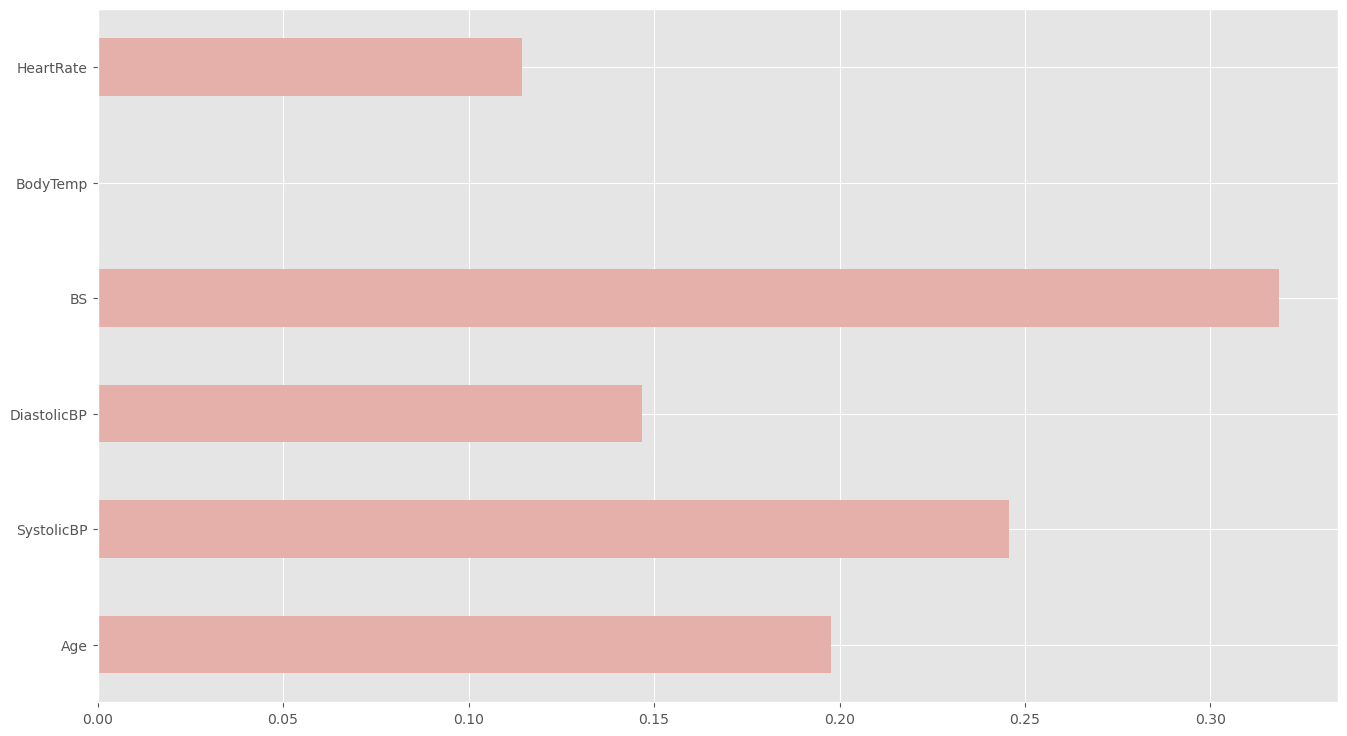

In [157]:
X_nueva = mutual_info_classif(X, y)
feat_imp = pd.Series(X_nueva, df.columns[0:len(df.columns)-1])
feat_imp.plot(kind='barh', color='#E6B0AA')
plt.show()

Dada la seleccion de atributos, observamos que los atributos con mayor peso son: BS y SystolicBP. Por loque se procede a realizar reducción de dimensionalidad con PCA,TSNE y UMAP

In [158]:
X1 = df[['BS', 'SystolicBP']]
y1 = df[['RiskLevel']]

In [159]:
#Reshape para tener la y de manera adimensional  
y1 = np.array(y1).reshape(1014)

### <font color='#DF615B  '>PCA </font>

PCA (Análisis de Componentes Principales) es una técnica de reducción de dimensionalidad lineal que proyecta los datos en un nuevo espacio de menor dimensión donde las variables están ordenadas por la cantidad de varianza que explican. PCA es una técnica poderosa y versátil que se puede utilizar para una variedad de tareas, incluyendo la reducción de dimensionalidad, la eliminación de ruido y la detección de anomalías.

In [160]:
X_PCA = PCA(n_components=2).fit_transform(X1)
#Realizamos la predicción por medio de la validación cruzada con k=10
y_pred = cross_val_predict(Clasificador, X_PCA, y1, cv=10)
cm = confusion_matrix(y1, y_pred) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y1, y_pred))

Confusion Matrix : 
 [[323  65  18]
 [176 118  42]
 [ 36  20 216]]
Test accuracy =  0.6479289940828402


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [161]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y1, y_pred)
print(TP, FP, TN, FN)

[323, 118, 216] [212, 85, 60] [334, 539, 441] [145, 272, 297]


Se obtiene la sensibilidad y la especificidad. 

In [162]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [163]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.47921225382932164 
Specificity:  0.7863554757630161


### <font color='#DF615B  '>TSNE </font>


t-SNE (t-Distributed Stochastic Neighbor Embedding) es una técnica de reducción de dimensionalidad no lineal que preserva la estructura local de los datos. t-SNE es un método iterativo que optimiza una función de pérdida que penaliza a los puntos que están cerca en el espacio de alta dimensión pero que están lejos en el espacio de baja dimensión. t-SNE es una técnica muy efectiva para visualizar datos de alta dimensión, pero puede ser computacionalmente intensiva para conjuntos de datos grandes.

In [164]:
X_TSNE = TSNE().fit_transform(X1)

#Realizamos la predicción por medio de la validación cruzada con k=10
y_pred = cross_val_predict(Clasificador, X_TSNE, y1, cv=10)
cm = confusion_matrix(y1, y_pred) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y1, y_pred))

Confusion Matrix : 
 [[289 101  16]
 [140 157  39]
 [ 60  66 146]]
Test accuracy =  0.5838264299802761


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [165]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y1, y_pred)
print(TP, FP, TN, FN)

[289, 157, 146] [200, 167, 55] [303, 435, 446] [222, 255, 367]


Se obtiene la sensibilidad y la especificidad. 

In [166]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [167]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.41225626740947074 
Specificity:  0.7372353673723536


### <font color='#DF615B  '>UAMAP </font>

UMAP (Uniform Manifold Approximation and Projection) es una técnica de reducción de dimensionalidad no lineal que es similar a t-SNE, pero que es más rápida y escalable. UMAP utiliza un enfoque diferente para optimizar la función de pérdida, lo que hace que sea más eficiente para conjuntos de datos grandes.

In [168]:
X_UMAP = UMAP(n_components=5).fit_transform(X1)

#Realizamos la predicción por medio de la validación cruzada con k=10
y_pred = cross_val_predict(Clasificador, X_UMAP, y1, cv=10)
cm = confusion_matrix(y1, y_pred) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y1, y_pred))

Confusion Matrix : 
 [[304  69  33]
 [174 116  46]
 [ 90  19 163]]
Test accuracy =  0.5749506903353058


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [169]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y1, y_pred)
print(TP, FP, TN, FN)

[304, 116, 163] [264, 88, 79] [279, 467, 420] [167, 343, 352]


Se obtiene la sensibilidad y la especificidad. 

In [170]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [171]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.40346020761245677 
Specificity:  0.7301189730745147


### Resultados obtenidos con selección de atributos  

A continuación, se muestra una tabla donde se observan los resultados obtenidos con el clasificador <font color='gren'>Árbol de decisiones </font> con los reductores de dimensionalidad PCA, TSNE y UMAP, además de selección de atributos

| Reductor | Accuracy | Sensitivity |Specificity|
|----------|----------|----------|--------|
| PCA    | 0.64   | 0.47   | 0.78   |
| TSNE   | 0.58   | 0.41   | 0.73  |
| UMAP    | 0.55   | 0.38   | 0.71  |

# <font color='#D82D64'>Se realiza el mismo tratado de los datos, pero sin realizar el preprocesamiento. Es decir, sin modificar las edades de las mujeres embarazadas. </font>

In [89]:
df = pd.read_csv(r'Maternal.csv')

A continuación, se muestra la gráfica de violín de las edades de las mujeres embarazadas sin modificar. 

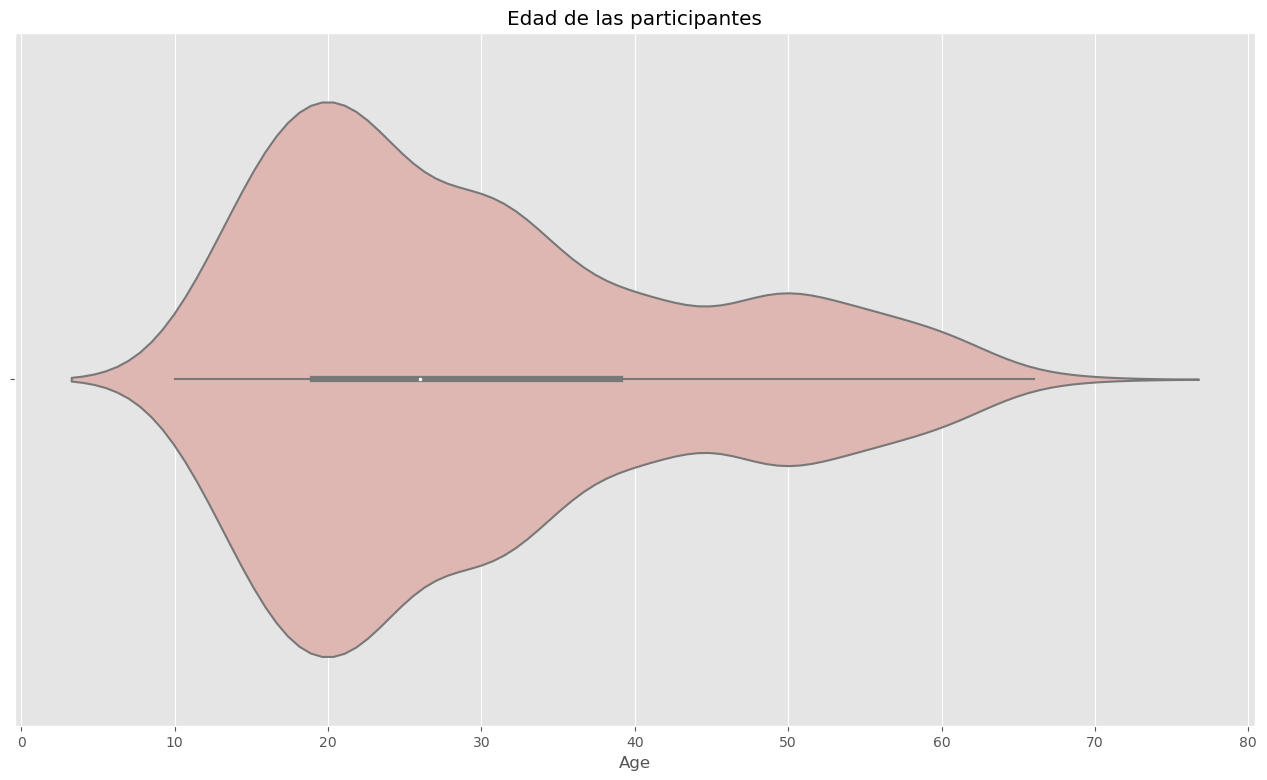

In [90]:
x=np.arange(len(df['Age']))
sns.violinplot(x=df["Age"], color='#E6B0AA');
plt.title("Edad de las participantes");

##  1er Objetivo 

Definimos las variables dependientes e independientes

In [91]:
X = df[['Age', 'SystolicBP', 'DiastolicBP','BS', 'BodyTemp', 'HeartRate']]
y = df[['RiskLevel']]

La función perf_measure esta diseñada para obtener TP, FP, TN, FN de una matriz de confusión MULTICLASE, por lo que esta función solamente será mandada a llamar.

In [92]:
#Función para obtener TP, FP, TN, FN de una matriz de confusión MULTICLASE
def perf_measure(y_actual, y_pred):
    class_id = set(y_actual).union(set(y_pred))
    TP = []
    FP = []
    TN = []
    FN = []

    for index ,_id in enumerate(class_id):
        TP.append(0)
        FP.append(0)
        TN.append(0)
        FN.append(0)
        for i in range(len(y_pred)):
            if y_actual[i] == y_pred[i] == _id:
                TP[index] += 1
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1
            if y_pred[i] != _id and y_actual[i] != y_pred[i]:
                FN[index] += 1


    return class_id,TP, FP, TN, FN

In [93]:
#Reshape para tener la y de manera adimensional  
y = np.array(y).reshape(1014)

### 1 <font color='green'>Árboles de Decisión</font>  


Los árboles de decisión son un tipo de algoritmo de aprendizaje automático supervisado que se utiliza para la clasificación y la regresión. Los árboles de decisión construyen un modelo de predicción a partir de un conjunto de datos de entrenamiento. El modelo se compone de un conjunto de reglas que se pueden utilizar para predecir el valor de una variable objetivo para una nueva observación.

In [94]:
Clasificador1 = DecisionTreeClassifier(max_depth=5, random_state=80)
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador1, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [95]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[365  37   4]
 [205  91  40]
 [ 24  45 203]]
Test accuracy =  0.6499013806706114


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [96]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[365, 91, 203] [229, 82, 44] [294, 568, 456] [126, 273, 311]


Se obtiene la sensibilidad y la especificidad. 

In [97]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [98]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.4813732651570489 
Specificity:  0.7878063359234907


### 2 <font color='#EE8983 '>Aprendizaje Bayesiano</font>

El aprendizaje bayesiano es un enfoque de aprendizaje automático que utiliza la teoría de la probabilidad bayesiana para hacer inferencias sobre los datos. La teoría de la probabilidad bayesiana se basa en la idea de que la probabilidad de un evento depende de la información previa que se tiene sobre ese evento.

In [99]:
Clasificador2 = GaussianNB()
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador2, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [100]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[330  36  40]
 [236  50  50]
 [ 49  53 170]]
Test accuracy =  0.5424063116370809


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [101]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[330, 50, 170] [285, 89, 90] [220, 500, 380] [179, 375, 374]


Se obtiene la sensibilidad y la especificidad. 

In [102]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [103]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.3721244925575101 
Specificity:  0.7033248081841432


### 3 <font color='#8B68D6 '>Aprendizaje basado en instancias </font>

El aprendizaje basado en instancias es un enfoque de aprendizaje automático en el que el modelo se construye a partir de un conjunto de datos de entrenamiento que contiene ejemplos de datos etiquetados. El modelo aprende a clasificar nuevas observaciones comparando las características de la observación con las características de las observaciones de entrenamiento.

In [104]:
Clasificador3 = KNeighborsClassifier(40)#Da valores similares para 2 y 40
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador3, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [105]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[212 164  30]
 [171 125  40]
 [ 91  38 143]]
Test accuracy =  0.47337278106508873


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [106]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[212, 125, 143] [262, 202, 70] [268, 355, 337] [272, 332, 464]


Se obtiene la sensibilidad y la especificidad. 

In [107]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [108]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.31007751937984496 
Specificity:  0.642570281124498


### 4 <font color='#B04ECB'>Máquinas de soporte vectorial (SVM)</font> 

In [109]:
Clasificador4 = SVC(kernel="linear", C=0.025, random_state=12)
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador4, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [110]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[327  70   9]
 [181 105  50]
 [ 44  44 184]]
Test accuracy =  0.6074950690335306


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [111]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[327, 105, 184] [225, 114, 59] [289, 511, 432] [173, 284, 339]


Se obtiene la sensibilidad y la especificidad. 

In [112]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [113]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.43626062322946174 
Specificity:  0.7558282208588957


### 5 <font color='#4E7FCB '>Redes neuronales</font>

El proceso de aprendizaje de las redes neuronales se llama entrenamiento. El entrenamiento se lleva a cabo utilizando un algoritmo de aprendizaje automático. Los algoritmos de aprendizaje automático se utilizan para ajustar los pesos y los sesgos de los nodos de la red neuronal. Los pesos y los sesgos controlan cómo se procesan las entradas en la red neuronal.

In [114]:
Clasificador5 = MLPClassifier(alpha=1, max_iter=1000, random_state=80)
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador5, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [115]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[311  81  14]
 [227  70  39]
 [ 73  16 183]]
Test accuracy =  0.5562130177514792


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [116]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[311, 70, 183] [300, 97, 53] [253, 494, 381] [150, 353, 397]


Se obtiene la sensibilidad y la especificidad. 

In [117]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [118]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.38524590163934425 
Specificity:  0.714828897338403


### 6 <font color='#DF5B91 '>AdaBoost</font>
AdaBoost funciona entrenando un conjunto de clasificadores débiles, cada uno de los cuales se enfoca en las observaciones que fueron mal clasificadas por los clasificadores anteriores. Los pesos de las observaciones se actualizan después de cada iteración para que los clasificadores futuros se centren en las observaciones que son más difíciles de clasificar.

In [119]:
Clasificador6 = AdaBoostClassifier(random_state=42)
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador6, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [120]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[272 118  16]
 [156 142  38]
 [ 25 130 117]]
Test accuracy =  0.5236686390532544


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [121]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[272, 142, 117] [181, 248, 54] [259, 389, 414] [302, 235, 429]


Se obtiene la sensibilidad y la especificidad. 

In [122]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [123]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.35470941883767537 
Specificity:  0.6873786407766991


### 7 <font color='#5B6FDF '>Random Forest</font>


Random Forest es un algoritmo de aprendizaje automático supervisado que se utiliza para la clasificación y la regresión. Random Forest es un conjunto de árboles de decisión aleatorios.
Random Forest funciona construyendo un conjunto de árboles de decisión aleatorios. Cada árbol de decisión se construye sobre un subconjunto aleatorio de los datos de entrenamiento. Las observaciones que se utilizan para construir un árbol de decisión son seleccionadas al azar sin reemplazo.

In [124]:
Clasificador7 = RandomForestClassifier(max_depth=6, n_estimators=15, max_features=3, random_state=42)
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador7, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [125]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[320  80   6]
 [187 101  48]
 [ 24  44 204]]
Test accuracy =  0.616370808678501


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [126]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[320, 101, 204] [211, 124, 54] [305, 524, 421] [178, 265, 335]


Se obtiene la sensibilidad y la especificidad. 

In [127]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [128]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.44547398431931573 
Specificity:  0.762660158633313


### 8 <font color='#5B6FDF '>QDA</font>

QDA, o Quadratic Discriminant Analysis, es un algoritmo de clasificación supervisado que se utiliza para clasificar las observaciones en diferentes categorías. QDA es un modelo probabilístico que se basa en la teoría de la probabilidad bayesiana.
QDA es un algoritmo robusto que es menos propenso al sobreajuste que otros algoritmos de clasificación. QDA también puede manejar datos complejos o no lineales.

In [129]:
Clasificador8 =  QuadraticDiscriminantAnalysis()
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador8, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [130]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[338  43  25]
 [173  91  72]
 [ 51  45 176]]
Test accuracy =  0.596646942800789


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [131]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[338, 91, 176] [224, 88, 97] [267, 514, 429] [185, 321, 312]


Se obtiene la sensibilidad y la especificidad. 

In [132]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [133]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.42515811665495434 
Specificity:  0.7473749227918468


### 9 <font color='#5B6FBF '>RBF SVM</font>

RBF SVM, o Radial Basis Function Support Vector Machine, es un algoritmo de aprendizaje automático supervisado que se utiliza para la clasificación y la regresión. RBF SVM es un tipo de máquina de soporte vectorial (SVM) que utiliza una función de núcleo radial para mapear los datos de entrada a un espacio de características de mayor dimensión.
RBF SVM funciona encontrando el hiperplano que separa mejor las observaciones de diferentes categorías en el espacio de características de mayor dimensión. El hiperplano es una línea o una superficie que divide el espacio de características en dos partes, una para cada categoría.

In [134]:
Clasificador9 =  SVC(gamma=2, C=1, random_state=42)
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador9, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [135]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[315  76  15]
 [238  74  24]
 [153  22  97]]
Test accuracy =  0.47928994082840237


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [136]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[315, 74, 97] [391, 98, 39] [171, 412, 389] [137, 430, 489]


Se obtiene la sensibilidad y la especificidad. 

In [137]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [138]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.3151750972762646 
Specificity:  0.648


### 10 <font color='#5B6FBF '>Gaussian Mixture Model</font>


Gaussian Mixture Model (GMM) es un modelo probabilístico que asume que los datos se generan a partir de una mezcla de un número finito de distribuciones Gaussianas. Las distribuciones Gaussianas individuales se denominan componentes.
Los GMM se pueden implementar utilizando una variedad de algoritmos, como el algoritmo EM y el algoritmo de propagación de creencias.

In [139]:
Clasificador10 = GaussianMixture(n_components=2)
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador10, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [140]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[  0   0   0   0]
 [178 228   0   0]
 [148 188   0   0]
 [ 79 193   0   0]]
Test accuracy =  0.22485207100591717


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [141]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[0, 228, 0, 0] [405, 381, 0, 0] [228, 0, 228, 228] [381, 405, 786, 786]


Se obtiene la sensibilidad y la especificidad. 

In [142]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [143]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.08816705336426914 
Specificity:  0.46530612244897956


## 2do Objetivo 
Comparar el rendimiento de los modelos utilizando los datos en su dominio original, respecto al utilizar los datos en un espacio modificado (e.g. PCA, LDA, t-SNE, UMAP, ...). Seleccionar el mejor modelo de clasificación para realizar la comparación con base en las métricas utilizadas previamente.

Resultados Obtenidos en el primer objetivo:

####  <font color='#6B6FBF '>Tabla de clasificadores y sus resultados respectivos. </font>

| Clasificador | Accuracy | Sensitivity |Specificity|
|----------|----------|----------|--------|
| Árbol de desición| [0.64](dot.com) | [0.48](dot.com)  |[0.78](dot.com)  |
| Aprendizaje Bayesiano   | 0.54   | 0.37   | 0.70  |
| Aprendizaje Basado en Instancias    | 0.47   |0.31   | 0.64  |
| SVM     | 0.60 | 0.43 | 0.75 |
| Redes Neuronales | 0.55 | 0.38 | 0.71 |
| AdaBoost | 0.52 | 0.35 | 0.68| 
| Random Forest | 0.61 | 0.44| 0.76|
| QDA | 0.59 | 0.42 | 0.74 |
| RBF SVM | 0.47 | 0.31 | 0.64 |
| Gaussian Mixture Model| 0.18 | 0.06 | 0.40|



En el estudio, se compararon varios modelos de inferencia, incluyendo SVM, Random Forest , Naive Bayes, etc. Los resultados mostraron que <font color='gren'>Árbol de decisiones </font> obtuvo los mejores resultados, con un Accuracy de  <font color='red'>0.64 </font> Sensitivity de  <font color='red'>0.48 </font> y Specificity de  <font color='red'>0.78 </font>. 


De esta manera utilizaremos  <font color='gren'>Árbol de decisiones </font> como clasificador. 

In [144]:
Clasificador = DecisionTreeClassifier(max_depth=5, random_state=80)

### <font color='#DF615B  '>PCA </font>

PCA (Análisis de Componentes Principales) es una técnica de reducción de dimensionalidad lineal que proyecta los datos en un nuevo espacio de menor dimensión donde las variables están ordenadas por la cantidad de varianza que explican. PCA es una técnica poderosa y versátil que se puede utilizar para una variedad de tareas, incluyendo la reducción de dimensionalidad, la eliminación de ruido y la detección de anomalías.

In [145]:
X_PCA = PCA(n_components=2).fit_transform(X)
#Realizamos la predicción por medio de la validación cruzada con k=10
y_pred = cross_val_predict(Clasificador, X_PCA, y, cv=10)
cm = confusion_matrix(y, y_pred) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y, y_pred))

Confusion Matrix : 
 [[243 113  50]
 [193  89  54]
 [ 81  44 147]]
Test accuracy =  0.4723865877712032


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [146]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[243, 89, 147] [274, 157, 104] [236, 390, 332] [261, 378, 431]


Se obtiene la sensibilidad y la especificidad. 

In [147]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [148]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.3092317624273725 
Specificity:  0.6416610850636303


### <font color='#DF615B  '>TSNE </font>


t-SNE (t-Distributed Stochastic Neighbor Embedding) es una técnica de reducción de dimensionalidad no lineal que preserva la estructura local de los datos. t-SNE es un método iterativo que optimiza una función de pérdida que penaliza a los puntos que están cerca en el espacio de alta dimensión pero que están lejos en el espacio de baja dimensión. t-SNE es una técnica muy efectiva para visualizar datos de alta dimensión, pero puede ser computacionalmente intensiva para conjuntos de datos grandes.

In [149]:
X_TSNE = TSNE().fit_transform(X)

#Realizamos la predicción por medio de la validación cruzada con k=10
y_pred = cross_val_predict(Clasificador, X_TSNE, y, cv=10)
cm = confusion_matrix(y, y_pred) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y, y_pred))

Confusion Matrix : 
 [[321  68  17]
 [236  66  34]
 [ 93  20 159]]
Test accuracy =  0.5384615384615384


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [150]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[321, 66, 159] [329, 88, 51] [225, 480, 387] [139, 380, 417]


Se obtiene la sensibilidad y la especificidad. 

In [151]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [152]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.3684210526315789 
Specificity:  0.7


### <font color='#DF615B  '>UAMAP </font>

UMAP (Uniform Manifold Approximation and Projection) es una técnica de reducción de dimensionalidad no lineal que es similar a t-SNE, pero que es más rápida y escalable. UMAP utiliza un enfoque diferente para optimizar la función de pérdida, lo que hace que sea más eficiente para conjuntos de datos grandes.

In [153]:
X_UMAP = UMAP(n_components=5).fit_transform(X)

#Realizamos la predicción por medio de la validación cruzada con k=10
y_pred = cross_val_predict(Clasificador, X_UMAP, y, cv=10)
cm = confusion_matrix(y, y_pred) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y, y_pred))

Confusion Matrix : 
 [[318  38  50]
 [267  33  36]
 [134  20 118]]
Test accuracy =  0.4625246548323471


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [154]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[318, 33, 118] [401, 58, 86] [151, 436, 351] [144, 487, 459]


Se obtiene la sensibilidad y la especificidad. 

In [155]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [156]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.3008338678640154 
Specificity:  0.6325016857720837


### Resultados obtenidos con los datos originales 

A continuación, se muestra una tabla donde se observan los resultados obtenidos con el clasificador <font color='gren'>Árbol de decisiones </font> con los reductores de dimensionalidad PCA, TSNE y UMAP

| Reductor | Accuracy | Sensitivity |Specificity|
|----------|----------|----------|--------|
| PCA    | 0.47   | 0.30   | 0.64   |
| TSNE   | 0.53   | 0.36   | 0.70  |
| UMAP    | 0.41   | 0.25   | 0.58  |

## Selección de Atributos

Observamos el peso de cada atributo con respecto a la clase

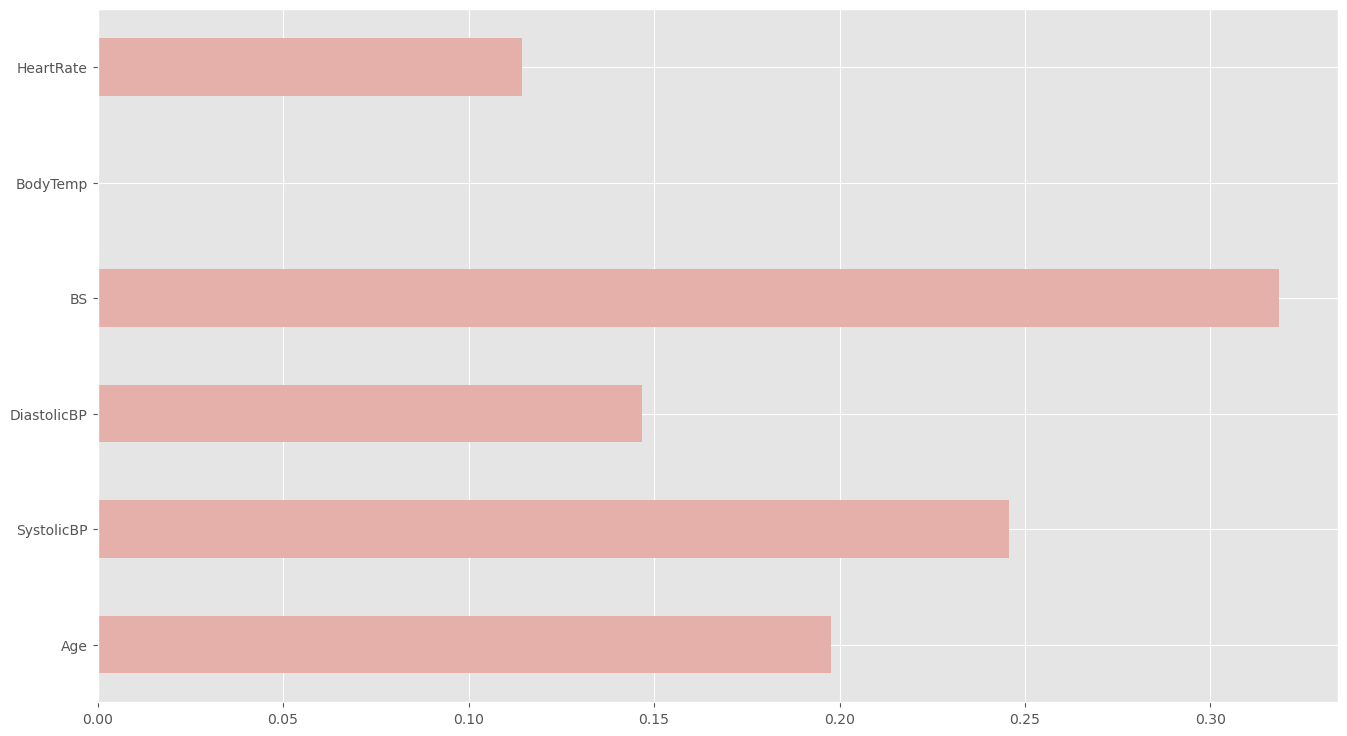

In [157]:
X_nueva = mutual_info_classif(X, y)
feat_imp = pd.Series(X_nueva, df.columns[0:len(df.columns)-1])
feat_imp.plot(kind='barh', color='#E6B0AA')
plt.show()

Dada la seleccion de atributos, observamos que los atributos con mayor peso son: BS y SystolicBP. Por loque se procede a realizar reducción de dimensionalidad con PCA,TSNE y UMAP

In [158]:
X1 = df[['BS', 'SystolicBP']]
y1 = df[['RiskLevel']]

In [159]:
#Reshape para tener la y de manera adimensional  
y1 = np.array(y1).reshape(1014)

### <font color='#DF615B  '>PCA </font>

PCA (Análisis de Componentes Principales) es una técnica de reducción de dimensionalidad lineal que proyecta los datos en un nuevo espacio de menor dimensión donde las variables están ordenadas por la cantidad de varianza que explican. PCA es una técnica poderosa y versátil que se puede utilizar para una variedad de tareas, incluyendo la reducción de dimensionalidad, la eliminación de ruido y la detección de anomalías.

In [160]:
X_PCA = PCA(n_components=2).fit_transform(X1)
#Realizamos la predicción por medio de la validación cruzada con k=10
y_pred = cross_val_predict(Clasificador, X_PCA, y1, cv=10)
cm = confusion_matrix(y1, y_pred) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y1, y_pred))

Confusion Matrix : 
 [[323  65  18]
 [176 118  42]
 [ 36  20 216]]
Test accuracy =  0.6479289940828402


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [161]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y1, y_pred)
print(TP, FP, TN, FN)

[323, 118, 216] [212, 85, 60] [334, 539, 441] [145, 272, 297]


Se obtiene la sensibilidad y la especificidad. 

In [162]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [163]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.47921225382932164 
Specificity:  0.7863554757630161


### <font color='#DF615B  '>TSNE </font>


t-SNE (t-Distributed Stochastic Neighbor Embedding) es una técnica de reducción de dimensionalidad no lineal que preserva la estructura local de los datos. t-SNE es un método iterativo que optimiza una función de pérdida que penaliza a los puntos que están cerca en el espacio de alta dimensión pero que están lejos en el espacio de baja dimensión. t-SNE es una técnica muy efectiva para visualizar datos de alta dimensión, pero puede ser computacionalmente intensiva para conjuntos de datos grandes.

In [164]:
X_TSNE = TSNE().fit_transform(X1)

#Realizamos la predicción por medio de la validación cruzada con k=10
y_pred = cross_val_predict(Clasificador, X_TSNE, y1, cv=10)
cm = confusion_matrix(y1, y_pred) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y1, y_pred))

Confusion Matrix : 
 [[289 101  16]
 [140 157  39]
 [ 60  66 146]]
Test accuracy =  0.5838264299802761


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [165]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y1, y_pred)
print(TP, FP, TN, FN)

[289, 157, 146] [200, 167, 55] [303, 435, 446] [222, 255, 367]


Se obtiene la sensibilidad y la especificidad. 

In [166]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [167]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.41225626740947074 
Specificity:  0.7372353673723536


### <font color='#DF615B  '>UAMAP </font>

UMAP (Uniform Manifold Approximation and Projection) es una técnica de reducción de dimensionalidad no lineal que es similar a t-SNE, pero que es más rápida y escalable. UMAP utiliza un enfoque diferente para optimizar la función de pérdida, lo que hace que sea más eficiente para conjuntos de datos grandes.

In [168]:
X_UMAP = UMAP(n_components=5).fit_transform(X1)

#Realizamos la predicción por medio de la validación cruzada con k=10
y_pred = cross_val_predict(Clasificador, X_UMAP, y1, cv=10)
cm = confusion_matrix(y1, y_pred) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y1, y_pred))

Confusion Matrix : 
 [[304  69  33]
 [174 116  46]
 [ 90  19 163]]
Test accuracy =  0.5749506903353058


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [169]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y1, y_pred)
print(TP, FP, TN, FN)

[304, 116, 163] [264, 88, 79] [279, 467, 420] [167, 343, 352]


Se obtiene la sensibilidad y la especificidad. 

In [170]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [171]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.40346020761245677 
Specificity:  0.7301189730745147


### Resultados obtenidos con selección de atributos  

A continuación, se muestra una tabla donde se observan los resultados obtenidos con el clasificador <font color='gren'>Árbol de decisiones </font> con los reductores de dimensionalidad PCA, TSNE y UMAP, además de selección de atributos

| Reductor | Accuracy | Sensitivity |Specificity|
|----------|----------|----------|--------|
| PCA    | 0.64   | 0.47   | 0.78   |
| TSNE   | 0.58   | 0.41   | 0.73  |
| UMAP    | 0.59   | 0.41   | 0.74  |

# <font color='#832DD8'>Discusión de Resultados </font>

#### Clasificadores
A continuación, en <font color='#EC7063'>Tabla 1 </font> se presentan los resultados obtenidos con el preprocesamiento de datos (Ajuste en el rango de edades de las mujeres embarazadas).

| Clasificador | Accuracy | Sensitivity |Specificity|
|----------|----------|----------|--------|
| Árbol de desición| [0.65](dot.com) | [0.48](dot.com)  |[0.79](dot.com)  |
| Aprendizaje Bayesiano   | 0.57   | 0.38   | 0.71  |
| Aprendizaje Basado en Instancias    | 0.50   |0.33   | 0.67  |
| SVM     | 0.60 | 0.43 | 0.75 |
| Redes Neuronales | 0.56 | 0.39 | 0.72 |
| AdaBoost | 0.49 | 0.33 | 0.66| 
| Random Forest | 0.60 | 0.43| 0.75|
| QDA | 0.57 | 0.40 | 0.72 |
| RBF SVM | 0.47 | 0.31 | 0.64 |
| Gaussian Mixture Model| 0.18 | 0.07 | 0.40|

En <font color='#EC7063'>Tabla 2 </font>, se presentan los resultados obtenidos con los datos originales del Dataframe

| Clasificador | Accuracy | Sensitivity |Specificity|
|----------|----------|----------|--------|
| Árbol de desición| [0.64](dot.com) | [0.48](dot.com)  |[0.78](dot.com)  |
| Aprendizaje Bayesiano   | 0.54   | 0.37   | 0.70  |
| Aprendizaje Basado en Instancias    | 0.47   |0.31   | 0.64  |
| SVM     | 0.60 | 0.43 | 0.75 |
| Redes Neuronales | 0.55 | 0.38 | 0.71 |
| AdaBoost | 0.52 | 0.35 | 0.68| 
| Random Forest | 0.61 | 0.44| 0.76|
| QDA | 0.59 | 0.42 | 0.74 |
| RBF SVM | 0.47 | 0.31 | 0.64 |
| Gaussian Mixture Model| 0.18 | 0.06 | 0.40|

Observamos que:
1. No hubo diferencias significativas entre los datos procesados y sin procesar. Esto significa que el procesamiento de datos no tuvo un impacto significativo en el rendimiento de los clasificadores.
2. Los clasificadores obtuvieron puntajes similares. Esto significa que no hubo un clasificador que claramente superase a los demás.
3. El mejor clasificador fue el árbol de decisión. El árbol de decisión es un clasificador simple pero poderoso que es a menudo una buena opción para problemas de clasificación.
4. El peor clasificador fue el modelo Gaussiano. El modelo Gaussiano es un clasificador lineal que puede ser sensible al ruido en los datos.

#### Reductores de Dimensionalidad

En <font color='#EC7063'>Tabla 3 </font> se muestran los resultados obtenidos con el preprocesamiento de datos (Ajuste en el rango de edades de las mujeres embarazadas). Además se emplea  el clasificador <font color='gren'>Árbol de decisiones </font> con los reductores de dimensionalidad PCA, TSNE y UMAP

| Reductor | Accuracy | Sensitivity |Specificity|
|----------|----------|----------|--------|
| PCA    | 0.44   | 0.28   | 0.61   |
| TSNE   | 0.54   | 0.37   | 0.70  |
| UMAP    | 0.39   | 0.24   | 0.56  |

En <font color='#EC7063'>Tabla 4 </font> se muestran los resultados obtenidos con los datos originales del Dataframe. Además se emplea  el clasificador <font color='gren'>Árbol de decisiones </font> con los reductores de dimensionalidad PCA, TSNE y UMAP

| Reductor | Accuracy | Sensitivity |Specificity|
|----------|----------|----------|--------|
| PCA    | 0.47   | 0.30   | 0.64   |
| TSNE   | 0.53   | 0.36   | 0.70  |
| UMAP    | 0.41   | 0.25   | 0.58  |

Para los reductores de dimensionalidad observamos un comportamiento similar al presentado en clasificadores, pues de igual forma no se presentan diferencias significativas entre los valores obtenidos para los datos que recibieron un procesamiento y para los que no. Cabe destacar que para ambos casos se empleo el modelo clasificador de Árbol de Decisiones.

#### Selección de Atributos

En <font color='#EC7063'>Tabla 5 </font>, se muestran los resultados obtenidos con el preprocesamiento de datos (Ajuste en el rango de edades de las mujeres embarazadas) con el clasificador <font color='gren'>Árbol de decisiones </font>, con los reductores de dimensionalidad PCA, TSNE y UMAP, además de selección de atributos en donde solo se utilizaron BS y SystolicBP

| Reductor | Accuracy | Sensitivity |Specificity|
|----------|----------|----------|--------|
| PCA    | 0.64   | 0.47   | 0.78   |
| TSNE   | 0.58   | 0.41   | 0.73  |
| UMAP    | 0.55   | 0.38   | 0.71  |

En <font color='#EC7063'>Tabla 6 </font>, se muestran los datos originales del Dataframe, con el clasificador <font color='gren'>Árbol de decisiones </font>, con los reductores de dimensionalidad PCA, TSNE y UMAP, además de selección de atributos en donde solo se utilizaron BS y SystolicBP

| Reductor | Accuracy | Sensitivity |Specificity|
|----------|----------|----------|--------|
| PCA    | 0.64   | 0.47   | 0.78   |
| TSNE   | 0.58   | 0.41   | 0.73  |
| UMAP    | 0.59   | 0.41   | 0.74  |

Para la selección de atributos observamos un comportamiento similar al presentado en clasificadoresy reductores de dimensionalidad, pues de igual forma no se presentan diferencias significativas entre los valores obtenidos para los datos que recibieron un procesamiento y para los que no. Cabe destacar que para ambos casos se empleo el modelo clasificador de Árbol de Decisiones.

# <font color='#632DD8'>Conclusión </font>

Los resultados sugieren que el procesamiento de datos no tuvo un impacto significativo en el rendimiento de los clasificadores. Los clasificadores obtuvieron puntajes similares, con el mejor resultado obtenido por el árbol de decisión y el peor por el modelo Gaussiano.

Estos resultados son consistentes con la literatura existente, que sugiere que el procesamiento de datos puede no ser necesario para mejorar el rendimiento de los clasificadores en muchos casos. Sin embargo, es importante tener en cuenta que estos resultados se basan en un conjunto de datos específico y que los resultados pueden variar para otros conjuntos de datos.

Además, los resultados del estudio sugieren que no existe un clasificador que claramente supere a los demás en todos los casos. El árbol de decisión fue el mejor clasificador en este estudio, pero otros clasificadores, como el modelo Gaussiano, pueden ser mejores para otros conjuntos de datos.

Por último, los resultados del estudio sugieren que los reductores de dimensionalidad y la selección de atributos pueden no ser necesarios para mejorar el rendimiento de los clasificadores en muchos casos. En este estudio, no se observaron diferencias significativas entre los valores obtenidos para los datos que recibieron un procesamiento y para los que no.